In [1]:
import numpy as np
from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from epsr import EPSR
import numpy as np
import numdifftools as nd
from scipy.stats import gaussian_kde
from utils import check_is_trigometric
from utils import optimal_interp_points, interp_matrix
import matplotlib.pyplot as plt
from numpy.linalg import eigh

In [2]:
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)

# Define the cost function in XXZ model

In [3]:
num_q = 5 # N # IMPORTANT
layer = 2  # Define the number of layers in the quantum circuit

In [4]:
Delta = 0.5 # IMPORTANT
List_1 = []
op = ""
op = "X"
for k in range(num_q-2):
    op += "I"
op += "X"
List_1.append(op)
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "XX"
    for k in range(i+1,num_q-1):
        op += "I"
    List_1.append(op)
List_1.reverse()
H1 = SparsePauliOp(List_1, np.ones(num_q))

List_2 = []
op = "Y"
for k in range(num_q-2):
    op += "I"
op += "Y"
List_2.append(op)
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "YY"
    for k in range(i+1,num_q-1):
        op += "I"
    List_2.append(op)
List_2.reverse()
H2 = SparsePauliOp(List_2, np.ones(num_q))

H_first = SparsePauliOp.sum([H1,H2])

List_3 = []
op = "Z"
for k in range(num_q-2):
    op += "I"
op += "Z"
List_3.append(op)  
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1):
        op += "I"
    List_3.append(op)

List_3.reverse()    
H_second = SparsePauliOp(List_3, Delta*np.ones(num_q))

# set H = H1 + H2
H = SparsePauliOp.sum([H_first,H_second])
Hmat = Operator(H)
Hmat = Hmat.data # This is the matrix representation of the Hamiltonian

# # Print with detailed descriptions
# print(f"Number of qubits (num_q): {num_q}")
# print(f"Delta value: {Delta}")
# print("List_1 (Pauli terms for XX interactions):")
# print(List_1)
# print("List_2 (Pauli terms for YY interactions):")
# print(List_2)
# print("List_3 (Pauli terms for ZZ interactions):")
# print(List_3)
# print(H.size)
# print(H)

In [5]:
# Compute eigenvalues and eigenvectors
e, v = eigh(Hmat)

# Identify the ground state (minimum eigenvalue)
ground_e = np.min(e)
min_index = np.argmin(e)
v_min = v[:, min_index]  # Ground state eigenvector

# Check degeneracy of the ground state
degeneracy = np.sum(np.isclose(e, ground_e))

# Print warning if ground state is not unique
if degeneracy > 1:
    print(f"Warning: Ground state is not unique. Degeneracy = {degeneracy}. Fidelity is not good metric.")
else:
    print("Ground state is unique.")
    
# Optional: Output for debugging
print(f"Ground state energy: {ground_e}")
print(f"Eigenvalues: {e}")

Ground state energy: -6.2805137690310255
Eigenvalues: [-6.28051377 -6.28051377 -6.28051377 -6.28051377 -2.73606798 -2.73606798
 -2.73606798 -2.73606798 -2.62310563 -2.62310563 -1.17570558 -1.17570558
 -1.17570558 -1.17570558  1.41177356  1.41177356  1.41177356  1.41177356
  1.73606798  1.73606798  1.73606798  1.73606798  2.04444579  2.04444579
  2.04444579  2.04444579  2.5         2.5         4.5         4.5
  5.62310563  5.62310563]


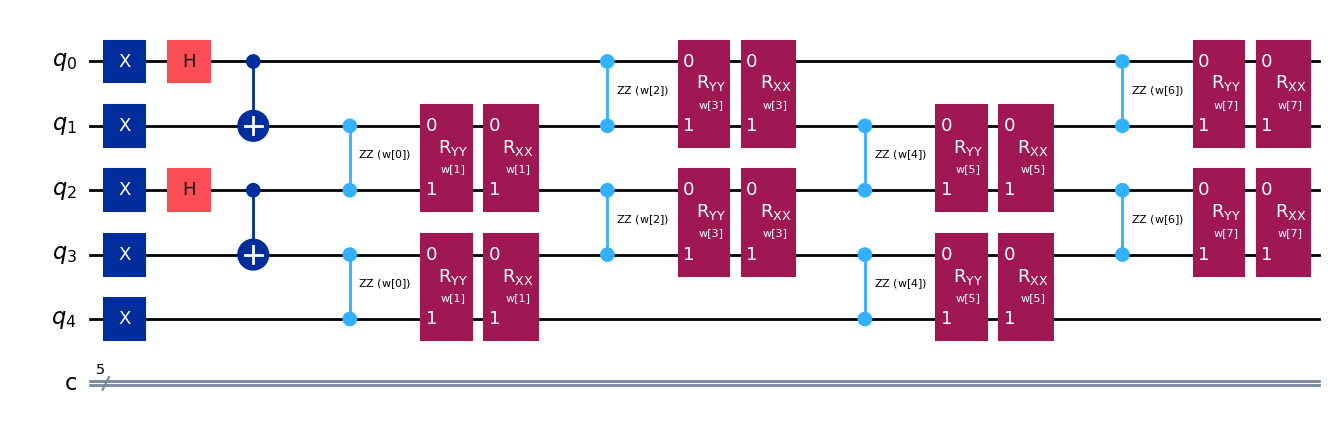

In [6]:
"""Circuit construction"""
# This needs to be determined based on the circuit
num_p = layer * 4  # Calculate the number of parameters

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

def circuit_QAOA_XXZ(weights):
    circ = QuantumCircuit(num_q, num_q)
    
    # Input layer to prepare Bell state -\psi
    for j in range(num_q):
        circ.x(j)  # Apply X gate to all qubits, initializing them from |0> to |1>.
    for j in range(int(num_q / 2)):
        # Then, for each pair of adjacent qubits (2j and 2j+1), apply H gate and CX (CNOT) gate to create Bell states.
        circ.h(2 * j)  # Apply Hadamard gate to each pair of qubits to create superposition states
        circ.cx(2 * j, 2 * j + 1)  # Create Bell state: Apply CNOT gate to each pair of qubits

    # QAOA Ansatz (variational layers)
    # Each layer consists of two parts: odd layers and even layers. The total number of layers is 'layer', with 2 sub-layers inside.
    for i in range(layer):
        ## Odd layers
        for j in range(int(num_q / 2)):
            circ.rzz(weights[4 * i], 2 * j + 1, (2 * j + 2) % num_q)  ## ZZ gates in odd sum
            # weights  [0]
        for j in range(int(num_q / 2)):
            circ.ryy(weights[4 * i + 1], 2 * j + 1, (2 * j + 2) % num_q)  ## YY gates in odd sum
            # weights  [1]
        for j in range(int(num_q / 2)):
            circ.rxx(weights[4 * i + 1], 2 * j + 1, (2 * j + 2) % num_q)  ## XX gates in odd sum
            # weights  [1]

        ## Even layers
        for j in range(int(num_q / 2)):
            circ.rzz(weights[4 * i + 2], 2 * j, 2 * j + 1)  ## ZZ gates in even sum
            # weights  [2]
        for j in range(int(num_q / 2)):
            circ.ryy(weights[4 * i + 3], 2 * j, 2 * j + 1)  ## YY gates in even sum
            # weights  [3]
        for j in range(int(num_q / 2)):
            circ.rxx(weights[4 * i + 3], 2 * j, 2 * j + 1)  ## XX gates in even sum
            # weights  [3]

    return circ 

qc = circuit_QAOA_XXZ(weights)
# print(qc)
qc.draw("mpl")


In [7]:
simulator = AerSimulator()

def estimate_loss(WEIGHTS, SHOTS):

    estimate_1 = 0
    estimate_2 = 0
    estimate_3 = 0

    ########################### XX
    qc = circuit_QAOA_XXZ(WEIGHTS)
    for i in range(num_q):
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q-1):
            if c_i[num_q-1-j] == c_i[num_q-1-(j+1)]:
                estimate_1 += 1
            else:
                estimate_1 += -1
        
        if c_i[num_q-1-0] == c_i[num_q-1-(num_q-1)]:
            estimate_1 += 1
        else:
            estimate_1 += -1

    estimate_1 = estimate_1/SHOTS

    ########################### YY
    qc = circuit_QAOA_XXZ(WEIGHTS)
    for i in range(num_q):
        qc.sdg(i)
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q-1):
            if c_i[num_q-1-j] == c_i[num_q-1-(j+1)]:
                estimate_2 += 1
            else:
                estimate_2 += -1
        
        if c_i[num_q-1-0] == c_i[num_q-1-(num_q-1)]:
            estimate_2 += 1
        else:
            estimate_2 += -1
            
    estimate_2 = estimate_2/SHOTS

    ########################### ZZ
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q-1):
            if c_i[num_q-1-j] == c_i[num_q-1-(j+1)]:
                estimate_3 += 1
            else:
                estimate_3 += -1
        
        if c_i[num_q-1-0] == c_i[num_q-1-(num_q-1)]:
            estimate_3 += 1
        else:
            estimate_3 += -1
            
    estimate_3 = estimate_3/SHOTS

    
    estimate = estimate_1 + estimate_2 + Delta*estimate_3

    return estimate

def expectation_loss(WEIGHTS):
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)


# Set omegas for each coordinate j

In [8]:
# Construct weights_dict
weights_dict = {}

d=1

for j in range(num_p):

    if j % 2 == 0:  # Odd layers with RZZ gates
        omegas = [1,2]
        r = len(omegas)
        interp_nodes = np.array([(2 * mu - 1) / (2 * r) * np.pi for mu in range(1, r + 1)])
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas,
            'r': r,
            'interp_nodes': interp_nodes,
        }

    elif j % 2 == 1:  # Even layers with RYY+RXX gates
        omegas = [1,2,3,4]
        r = len(omegas)
        interp_nodes = np.array([(2 * mu - 1) / (2 * r) * np.pi for mu in range(1, r + 1)])
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas,
            'r': r,
            'interp_nodes': interp_nodes,
        }
    
    if j == 7:
        omegas = [1,2,4]
        # omegas = [1,2,3,4,5,6]
        r = len(omegas)
        interp_nodes = np.array([(2 * mu - 1) / (2 * r) * np.pi for mu in range(1, r + 1)])
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas,
            'r': r,
            'interp_nodes': interp_nodes,
        }

# # Print example results
# print(len(weights_dict))
# for i in range(len(weights_dict)):
#     print(weights_dict[f'weights_{i}'])


In [9]:
# Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas


# Define random weights
weights = np.random.normal(0, 4 * np.pi**2, num_p)

# Loop over each weight index and check trigonometric interpolation
for j in range(num_p):
    # Circuit_HEA is simple and all Hermitian generators are Y.
    omegas = weights_dict[f'weights_{j}']['omegas']  # This needs to be determined based on the circuit (i.e., parameters to test interpolation)
    
    print('\n index to check = ', j)
    print('omegas = ', omegas)
    
    opt_interp_flag = False  # Flag to indicate if optimal interpolation should be used
    
    # Call the function to check if the objective function can be interpolated using trigonometric interpolation
    check_is_trigometric(expectation_loss, j, omegas, weights, opt_interp_flag)


 index to check =  0
omegas =  [1, 2]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-0.89859444 -0.59736988  0.07270823 -0.44224271 -0.11515196]

 index to check =  1
omegas =  [1, 2, 3, 4]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-0.87808212 -0.69555542  0.30593798 -0.22242304  0.09507171 -0.17594392
 -0.11752784 -0.0739548  -0.01796278]

 index to check =  2
omegas =  [1, 2]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-0.68040928  0.00526192 -0.32961172 -0.07028302 -0.41991962]

 index to check =  3
omegas =  [1, 2, 3, 4]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-0.99503366 -0.07909012  0.10095955  0.15174564  0.04008863  0.02096955
  0.03385587 -0.00414919 -0.01331994]

 index to check =  4
omegas =  [1, 2]
Consistent results: 50/50
【All Passed】
Estimated coefficients:  [-0.00895011  0.2604503  -1.20364803 -0.68340352  0.31228837]

 index to check =  5
omegas =  [1, 2, 3, 4]
Consistent results: 

# Result I: validating the correctness of EPSR in a noise-free ideal setting

## Setting and test

In [10]:
def compute_derivative_using_psr_ture(x0, f_univariate, d, Omegas, nodes):

    # for univariate function f(x)
    Omegas = np.array(Omegas)
    b=EPSR(nodes, Omegas, d)

    if d % 2 == 1:
        gamma = 0.5 * np.hstack((b, -b))
    else:
        gamma = 0.5 * np.hstack((b, b))
    
    phi = np.hstack((nodes, -nodes))
    shifted_x0 = x0 + phi
    f_values = np.array([f_univariate(value) for value in shifted_x0])
    der = np.sum(gamma * f_values)
    return der, b

weights = np.random.uniform(0, 2*np.pi, size=num_p)

# j = np.random.randint(num_p)
j=0

ture_univariate_fun = lambda x: expectation_loss(np.concatenate([weights[:j], [x], weights[j+1:]]))

d=1
# d=2
# d=3
# d=4

Omegas=weights_dict[f'weights_{j}']['omegas']
r = weights_dict[f'weights_{j}']['r']

# nodes = np.array([(2 * mu - 1) / (2 * r) * np.pi for mu in range(1, r + 1)])
if d % 2 == 1:
    nodes = np.random.uniform(0, np.pi, r)
else:
    nodes = np.random.uniform(0, np.pi, r+1)

x0 = np.random.uniform(0, np.pi)
x0 = 0

psr_derivitive, b = compute_derivative_using_psr_ture(x0, ture_univariate_fun, d, Omegas, nodes)
print(psr_derivitive)
print(b)

# use numdifftools to cumpute correct answer
num_derivitive = nd.Derivative(ture_univariate_fun, n=d)(x0)
print(num_derivitive)

print(np.isclose(psr_derivitive, num_derivitive))

-2.3600722215284673
[ 7.43290337 -0.01415944]
-2.3600722215282133
True


In [11]:
# Assuming we compute errors for different values of d
d_values = range(1, 7)  # Choose the range of d values
avg_errors = []  # Store the average error for each d

for d in d_values:
    errors_for_d = []  # Store all errors for the current d value
    
    # Select 10 random nodes
    for _ in range(1):
        # Generate random nodes
        if d % 2 == 1:
            nodes = np.random.uniform(0, np.pi, r)  # Generate random nodes
        else:
            nodes = np.random.uniform(0, np.pi, r + 1)  # Generate random nodes
        
        # Compute the PSR derivative and the true derivative
        psr_derivative, _ = compute_derivative_using_psr_ture(x0, ture_univariate_fun, d, Omegas, nodes)
        num_derivative = nd.Derivative(ture_univariate_fun, n=d)(x0)
        
        # Calculate the error
        error = np.abs(psr_derivative - num_derivative)
        errors_for_d.append(error)
    
    # Calculate the average, minimum, and maximum errors for the current d
    avg_errors.append(np.mean(errors_for_d))


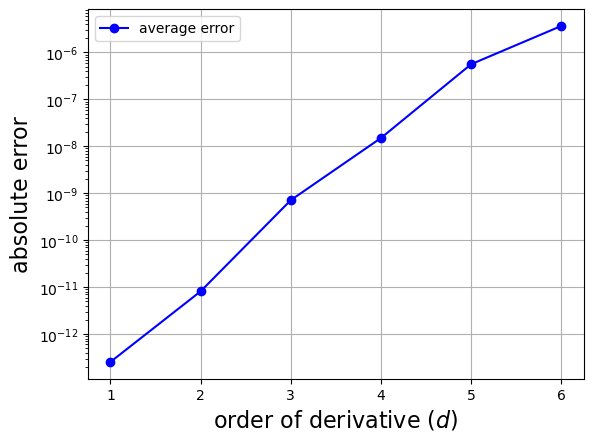

In [12]:
# Plot the error as a function of d
plt.plot(d_values, avg_errors, marker='o', linestyle='-', color='b', label='average error')
# plt.plot(d_values, min_errors, marker='s', linestyle='--', color='g', label='Min Error')
# plt.plot(d_values, max_errors, marker='^', linestyle='-.', color='r', label='Max Error')

# Set the title and labels for the plot
# plt.title(r'Error of Derivative vs. $d$ (with random nodes)')
plt.xlabel(r'order of derivative ($d$)', fontsize=16)
plt.xticks(d_values)  # Set the x-axis ticks to integers
plt.ylabel('absolute error', fontsize=16)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)
plt.legend()
plt.show()


## The previous ones are temporary tests, and below is the official code for the paper's images.

In [13]:
def compute_derivative_using_psr_ture(x0, f_univariate, d, Omegas, nodes):
    # for univariate function f(x)
    Omegas = np.array(Omegas)
    b = EPSR(nodes, Omegas, d)

    if d % 2 == 1:
        gamma = 0.5 * np.hstack((b, -b))
    else:
        gamma = 0.5 * np.hstack((b, b))
    
    phi = np.hstack((nodes, -nodes))
    shifted_x0 = x0 + phi
    f_values = np.array([f_univariate(value) for value in shifted_x0])
    der = np.sum(gamma * f_values)
    return der, b

# Set parameters
num_p = 8
d_values = list(range(1, 7))
weights = np.random.uniform(0, 2*np.pi, size=num_p)

labels = [r'$\theta_1$', r'$\phi_1$', r'$\beta_1$', r'$\gamma_1$', 
          r'$\theta_2$', r'$\phi_2$', r'$\beta_2$', r'$\gamma_2$']

# Store error curves for each parameter j
all_errors = []

# Main loop to compute errors for each parameter j
for j in range(num_p):
    x0 = weights[j]

    # Construct the target function
    ture_univariate_fun = lambda x: expectation_loss(np.concatenate([weights[:j], [x], weights[j+1:]]))
    Omegas = weights_dict[f'weights_{j}']['omegas']
    r = weights_dict[f'weights_{j}']['r']

    avg_errors = []

    for d in d_values:
        errors_for_d = []

        for _ in range(1):
            if d % 2 == 1:
                nodes = np.random.uniform(0, np.pi, r)
            else:
                nodes = np.random.uniform(0, np.pi, r + 1)

            psr_derivative, _ = compute_derivative_using_psr_ture(x0, ture_univariate_fun, d, Omegas, nodes)
            num_derivative = nd.Derivative(ture_univariate_fun, n=d)(x0)
            error = np.abs(psr_derivative - num_derivative)
            errors_for_d.append(error)

        avg_errors.append(np.mean(errors_for_d))

    all_errors.append(avg_errors)


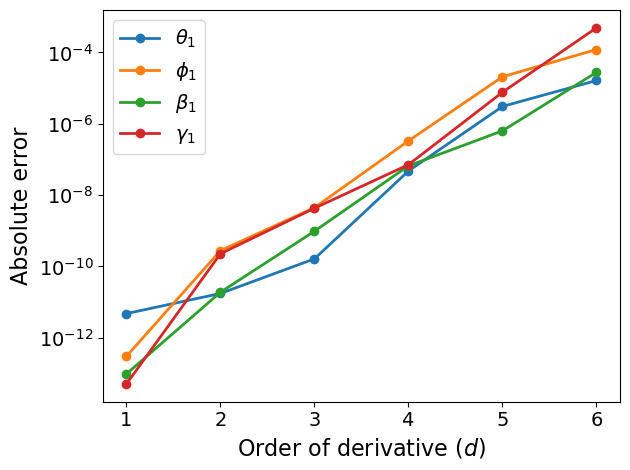

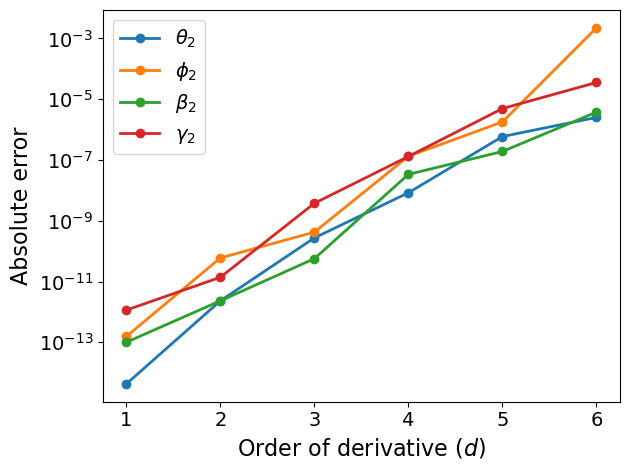

In [14]:
group1_labels = labels[:4]
group2_labels = labels[4:]

# ================= Group 1 =================
# plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(d_values, all_errors[i], marker='o', label=group1_labels[i], linewidth=2)

plt.xlabel(r'Order of derivative ($d$)', fontsize=16)
plt.ylabel('Absolute error', fontsize=16)
plt.xticks(d_values, fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.grid(False)
plt.legend(fontsize=14)
# plt.title('Group 1: Qubit 1', fontsize=16)
plt.tight_layout()
plt.show()

# ================= Group 2 =================
# plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(d_values, all_errors[i+4], marker='o', label=group2_labels[i], linewidth=2)

plt.xlabel(r'Order of derivative ($d$)', fontsize=16)
plt.ylabel('Absolute error', fontsize=16)
plt.xticks(d_values, fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.grid(False)
plt.legend(fontsize=14)
# plt.title('Group 2: Qubit 2', fontsize=16)
plt.tight_layout()
plt.show()


# Test: The function value is unbiased.

In [15]:
# weights = np.random.uniform(0, 2*np.pi, size=num_p)

# # Check if the observed values from the simulator follow a normal distribution
# # Essentially, this is to check whether the estimate_loss function is correct
# # It takes a long time
# shots = 1000
# if True:
#     true_value = expectation_loss(weights)

#     num_trials = 3000
#     estimate_results = [estimate_loss(weights, shots) for _ in range(num_trials)]

#     plt.figure(figsize=(10, 6))
#     plt.hist(estimate_results, bins=15, density=True, alpha=0.6, color='g', label='Estimation Results')
#     plt.axvline(true_value, color='r', linestyle='--', label=f'True Value = {true_value}')
#     plt.title('Distribution of estimate_Z outputs')
#     plt.xlabel('Estimated value')
#     plt.ylabel('Frequency')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


# Test: noised EPSR

In [16]:
weights = np.random.uniform(0, 2*np.pi, size=num_p)

j=0

def noise_univariate_fun(x,Nx_shots):
    return estimate_loss(np.concatenate([weights[:j], [x], weights[j+1:]]), Nx_shots)

def ture_univariate_fun(x):
    return expectation_loss(np.concatenate([weights[:j], [x], weights[j+1:]]))

def compute_derivative_using_psr(x0, noise_univariate_fun, N_total, d, Omegas, nodes, shot_scheme = 'weighted'):
    # for univariate function f(x)

    b = EPSR(nodes, np.array(Omegas), d)

    if d % 2 == 1:
        gamma = 0.5 * np.hstack((b, -b)) # for odd d
    else:
        gamma = 0.5 * np.hstack((b, b)) # for even d
    
    if shot_scheme == 'weighted':
        gamma_l1norm = np.sum(np.abs(gamma))
        Nx_list = [int(N_total * np.abs(gamma[i]) / gamma_l1norm) for i in range(len(gamma))]
    elif shot_scheme == 'uniform':
        Nx_list = [int(N_total / len(gamma)) for _ in range(len(gamma))]

    phi = np.hstack((nodes, -nodes))
    shifted_x0 = x0 + phi
    f_values = np.array([noise_univariate_fun(value, Nx) for value, Nx in zip(shifted_x0, Nx_list)])
    derivative = np.sum(gamma * f_values)

    if shot_scheme == 'weighted':
        total_var = np.sum(np.abs(b))**2
    elif shot_scheme == 'uniform':
        total_var = len(b) * np.sum(np.abs(b)**2)
    return derivative, b, total_var


d=1
Omegas=weights_dict[f'weights_{j}']['omegas']
r = weights_dict[f'weights_{j}']['r']

if d % 2 == 1:
    # nodes = np.random.uniform(0, np.pi, r)
    nodes_equi = np.array([(2 * mu - 1) / (2 * r) * np.pi for mu in range(1, r + 1)])
else:
    # nodes = np.random.uniform(0, np.pi, r+1)
    nodes_equi = np.array([ mu * (np.pi / r)  for mu in range(0, r + 1)])

# x0 = np.random.uniform(0, np.pi)
x0=0

N_total = 10000
shot_scheme = 'weighted'
shot_scheme = 'uniform'
compute_derivative_using_psr(x0, noise_univariate_fun, N_total, d, Omegas, nodes_equi, shot_scheme)



(1.5019800425623218, array([ 1.70710678, -0.29289322]), 6.0)

# Result II: weighted scheme outperforms uniform scheme

You need to manually modify the following:
```python
j = 1  # [1, 2, 3, 4]
# j = 0  # [1, 2]
```
to plot two separate figures.

In [ ]:
weights = np.random.uniform(0, 2*np.pi, size=num_p)

j=1 # [1,2,3,4]
# j=0 # [1,2]

def noise_univariate_fun(x,Nx_shots):
    return estimate_loss(np.concatenate([weights[:j], [x], weights[j+1:]]), Nx_shots)

def ture_univariate_fun(x):
    return expectation_loss(np.concatenate([weights[:j], [x], weights[j+1:]]))

d=1
Omegas=weights_dict[f'weights_{j}']['omegas']
r = weights_dict[f'weights_{j}']['r']

nodes_equi = np.array([(2 * mu - 1) / (2 * r) * np.pi for mu in range(1, r + 1)])
x0=weights[j]

# use numdifftools to compute correct answer
true_value = nd.Derivative(ture_univariate_fun, n=d)(x0)
print(true_value)

-0.9278712217943296


: 

In [ ]:
N_total = 1000

# Initialize estimate results list
num_trials = 500

# Loop to calculate derivative estimates
estimate_results_1= []
for _ in range(num_trials):
    psr_derivitive, b1, t_var1 = compute_derivative_using_psr(
        x0, noise_univariate_fun, N_total, d, Omegas, nodes_equi, 'uniform')
    estimate_results_1.append(psr_derivitive)

estimate_results_2 = []
for _ in range(num_trials):
    psr_derivitive_2, b2, t_var2 = compute_derivative_using_psr(
        x0, noise_univariate_fun, N_total, d, Omegas, nodes_equi, 'weighted')
    estimate_results_2.append(psr_derivitive_2)

# Convert results to numpy array for KDE
estimate_results_1 = np.array(estimate_results_1)
estimate_results_2 = np.array(estimate_results_2)

print(t_var1)
print(t_var2)

In [ ]:
# Plotting the figure
plt.figure(figsize=(10, 6))

# Estimate the PDF for uniform scheme nodes
kde_node_equi = gaussian_kde(estimate_results_1, bw_method='scott')
x_vals = np.linspace(min(estimate_results_1), max(estimate_results_1), 1000)
plt.plot(x_vals, kde_node_equi(x_vals), 
         label='uniform scheme', 
         color='b', linewidth=2)

# Estimate the PDF for weighted scheme nodes
kde_node_1 = gaussian_kde(estimate_results_2, bw_method='scott')
# x_vals = np.linspace(min(estimate_results_nodes_random_1), max(estimate_results_nodes_random_1), 1000)
plt.plot(x_vals, kde_node_1(x_vals), 
         label='weighted scheme', 
         color='g', linewidth=2
         )

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Plot the vertical line for the true value
plt.axvline(true_value, color='r', linestyle='--', 
            label=f'true derivative'
            )

# Set title and axis labels' font size
plt.title('Distribution of PDF estimates', fontsize=16)
plt.xlabel('Estimated value', fontsize=16)
plt.ylabel('Density', fontsize=16)

# Set the legend font size
plt.legend(fontsize=16)

# Remove the grid lines
plt.grid(False)

# Show the plot
plt.show()


# Result III: equidistant PSR nodes outperform random nodes under the weighted scheme

You need to manually modify the following:
```python
j = 1  # [1, 2, 3, 4]
# j = 0  # [1, 2]
```
to plot two separate figures.

In [ ]:
weights = np.random.uniform(0, 2*np.pi, size=num_p)

j=1 # [1,2,3,4]
# j=0 # [1,2]

x0=weights[j]

def noise_univariate_fun(x,Nx_shots):
    return estimate_loss(np.concatenate([weights[:j], [x], weights[j+1:]]), Nx_shots)

def ture_univariate_fun(x):
    return expectation_loss(np.concatenate([weights[:j], [x], weights[j+1:]]))

d=1
Omegas=weights_dict[f'weights_{j}']['omegas']
r = weights_dict[f'weights_{j}']['r']

nodes_equi = np.array([(2 * mu - 1) / (2 * r) * np.pi for mu in range(1, r + 1)])

# use numdifftools to compute correct answer
true_value = nd.Derivative(ture_univariate_fun, n=d)(x0)
print(true_value)


0.1517388594986149


In [ ]:
N_total = 1000

# Initialize estimate results list
num_trials = 500

nodes_equi = np.array([(2 * mu - 1) / (2 * r) * np.pi for mu in range(1, r + 1)])
nodes_random_1 = np.random.uniform(0, np.pi, r)
nodes_random_2 = np.random.uniform(0, np.pi, r)

shot_scheme = 'weighted'

# Loop to calculate derivative estimates
estimate_results_nodes_equi = []
for _ in range(num_trials):
    psr_derivitive, b_equi, t_var_equi = compute_derivative_using_psr(x0, noise_univariate_fun, N_total, d, Omegas, nodes_equi, shot_scheme)
    estimate_results_nodes_equi.append(psr_derivitive)
    
estimate_results_nodes_random_1 = []
for _ in range(num_trials):
    psr_derivitive_2, b1, t_var1 = compute_derivative_using_psr(x0, noise_univariate_fun, N_total, d, Omegas, nodes_random_1, shot_scheme)
    estimate_results_nodes_random_1.append(psr_derivitive_2)
    

estimate_results_nodes_random_2 = []
for _ in range(num_trials):
    psr_derivitive_2, b2, t_var2 = compute_derivative_using_psr(x0, noise_univariate_fun, N_total, d, Omegas, nodes_random_2, shot_scheme)
    estimate_results_nodes_random_2.append(psr_derivitive_2)

print(t_var_equi)
print(t_var1)    
print(t_var2)


16.0
125.19167415609641
40398.793933749526


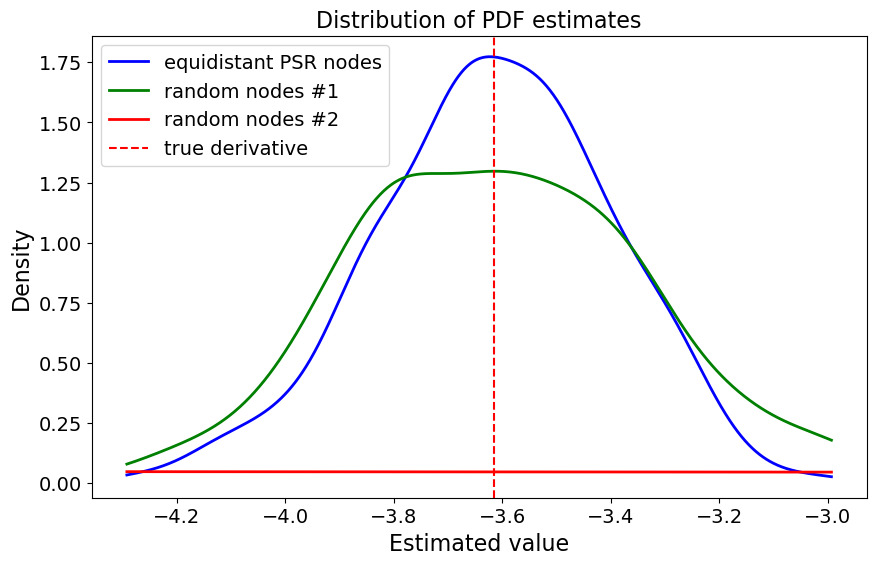

In [ ]:
# Convert results to numpy array for KDE
estimate_results_nodes_equi = np.array(estimate_results_nodes_equi)
estimate_results_nodes_random_1 = np.array(estimate_results_nodes_random_1)
estimate_results_nodes_random_2 = np.array(estimate_results_nodes_random_2)

# Plotting the figure
plt.figure(figsize=(10, 6))

# Estimate the PDF for equidistant PSR nodes
kde_node_equi = gaussian_kde(estimate_results_nodes_equi, bw_method='scott')
x_vals = np.linspace(min(estimate_results_nodes_equi), max(estimate_results_nodes_equi), 1000)
plt.plot(x_vals, kde_node_equi(x_vals), 
         label='equidistant PSR nodes', 
         color='b', linewidth=2)

# Estimate the PDF for random node 1
kde_node_1 = gaussian_kde(estimate_results_nodes_random_1, bw_method='scott')
plt.plot(x_vals, kde_node_1(x_vals), 
         label='random nodes #1', 
         color='g', linewidth=2)

# Estimate the PDF for random node 2
kde_node_2 = gaussian_kde(estimate_results_nodes_random_2, bw_method='scott')
plt.plot(x_vals, kde_node_2(x_vals), 
         label='random nodes #2', 
         color='r', linewidth=2)

# Plot the vertical line for the true value
plt.axvline(true_value, color='r', linestyle='--', 
            label=f'true derivative'
            )

# Customize ticks and labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Set title and axis labels' font size
plt.title('Distribution of PDF estimates', fontsize=16)
plt.xlabel('Estimated value', fontsize=16)
plt.ylabel('Density', fontsize=16)

# Set the legend font size
plt.legend(fontsize=14)

# Remove the grid lines
plt.grid(False)

# Show the plot
plt.show()


# [Not included in the paper] Experiment 4: The uniform scheme with equidistant PSR is not the best, and there are better nodes. However, numerically, the difference is actually not significant.

In [ ]:
weights = np.random.uniform(0, 2*np.pi, size=num_p)

j=1 # [1,2,3,4]

def noise_univariate_fun(x,Nx_shots):
    return estimate_loss(np.concatenate([weights[:j], [x], weights[j+1:]]), Nx_shots)

def ture_univariate_fun(x):
    return expectation_loss(np.concatenate([weights[:j], [x], weights[j+1:]]))

d=1
Omegas=weights_dict[f'weights_{j}']['omegas']
r = weights_dict[f'weights_{j}']['r']

nodes_equi = np.array([(2 * mu - 1) / (2 * r) * np.pi for mu in range(1, r + 1)])
x0=0

# use numdifftools to compute correct answer
true_value = nd.Derivative(ture_univariate_fun, n=d)(x0)
print(true_value)

In [ ]:
from scipy.optimize import differential_evolution, basinhopping, shgo

def L2norm2FinalVar(x, Omegas, d):
    b=EPSR(x, Omegas, d)
    return 0.5*np.sum(np.abs(b)**2)

L2norm2_objective = lambda x: L2norm2FinalVar(x, Omegas, d)

# Define bounds for optimization (0 to pi for each variable)
bounds = [(0.01, np.pi-0.01) for _ in range(r)]

result = differential_evolution(L2norm2_objective, bounds)

# Optimal x_mu and corresponding minimized l1 norm
optimal_nodes = result.x
optimal_nodes.sort()

print(nodes_equi)
print(L2norm2_objective(nodes_equi))
print(optimal_nodes)
print(L2norm2_objective(optimal_nodes))

In [ ]:
N_total = 1000

# Initialize estimate results list
num_trials = 500

shot_scheme = 'uniform'

# Loop to calculate derivative estimates
estimate_results_nodes_equi = []
for _ in range(num_trials):
    psr_derivitive, b1, t1 = compute_derivative_using_psr(x0, noise_univariate_fun, N_total, d, Omegas, nodes_equi, shot_scheme)
    estimate_results_nodes_equi.append(psr_derivitive)

estimate_results_nodes_optimal = []
for _ in range(num_trials):
    psr_derivitive_2, b2, t2 = compute_derivative_using_psr(x0, noise_univariate_fun, N_total, d, Omegas, optimal_nodes, shot_scheme)
    estimate_results_nodes_optimal.append(psr_derivitive_2)

# Convert results to numpy array for KDE
estimate_results_nodes_equi = np.array(estimate_results_nodes_equi)
estimate_results_nodes_optimal = np.array(estimate_results_nodes_optimal)

print(b1)
print(b2)
print(t1)
print(t2)

In [ ]:
# Plotting the figure
plt.figure(figsize=(10, 6))

# Estimate the PDF for equidistant nodes
kde_node_equi = gaussian_kde(estimate_results_nodes_equi, bw_method='scott')
x_vals = np.linspace(min(estimate_results_nodes_equi), max(estimate_results_nodes_equi), 1000)
plt.plot(x_vals, kde_node_equi(x_vals), 
         label='PDF Estimate using node equi', 
         color='b', linewidth=2)

# Estimate the PDF for optimal nodes
kde_node_1 = gaussian_kde(estimate_results_nodes_optimal, bw_method='scott')
# x_vals = np.linspace(min(estimate_results_nodes_random_1), max(estimate_results_nodes_random_1), 1000)
plt.plot(x_vals, kde_node_1(x_vals), 
         label='PDF Estimate using optimal', 
         color='g', linewidth=2)

# Plot the vertical line for the true value
plt.axvline(true_value, color='r', linestyle='--', 
            label=f'true derivative'
            )

# Set title and axis labels' font size
plt.title('Distribution of PDF estimates', fontsize=16)
plt.xlabel('Estimated value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Set the legend font size
plt.legend(fontsize=12)

# Remove the grid lines
plt.grid(False)

# Show the plot
plt.show()
